# Readout Error Mitigation via Parametric Compilation

This notebook walks through how to run 2Q **Max-Cut QAOA** on a noisy QVM, using _parametric compilation_ and pyQuil's `Experiment` framework. It shows how to use the framework to run a variational hybrid algorithm (VHA) with *readout symmetrization*, and then use the results of a _readout calibration_ to correct for readout error and improve algorithm results. This notebook is copied partially from the [rigetti/qcs-paper](https://github.com/rigetti/qcs-paper) repository, where it was used to produce **Figure 6** from [_A quantum-classical cloud platform optimized for variational hybrid algorithms_](https://scirate.com/arxiv/2001.04449).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from pyquil import get_qc, Program
from pyquil.gates import CNOT, H, MEASURE, RESET, RZ
from pyquil.experiment import ExperimentSetting, Experiment, correct_experiment_result
from pyquil.paulis import sZ

## Simulate Max-Cut QAOA on a Noisy QVM

In [2]:
q0, q1 = (0, 1)
# fewer shots so it runs faster
shots = 500
gammas = np.linspace(-np.pi / 2, np.pi / 2, 100)
qc = get_qc("2q-noisy-qvm")

### Define Max-Cut QAOA `Experiment`

In [3]:
p = Program()
p += RESET()
gamma = p.declare("gamma", "REAL")
p += H(q0)
p += H(q1)
p += CNOT(q0,q1)
p += RZ(2*gamma, q1)
p += CNOT(q0,q1)
p += H(q0)
p += H(q1)
p += RZ(np.pi/4, q0)
p += RZ(np.pi/4, q1)
p += H(q0)
p += H(q1)
p.wrap_in_numshots_loop(shots)
print(p)

RESET
DECLARE gamma REAL[1]
H 0
H 1
CNOT 0 1
RZ(2*gamma) 1
CNOT 0 1
H 0
H 1
RZ(pi/4) 0
RZ(pi/4) 1
H 0
H 1



In [4]:
zz_zz = ExperimentSetting(in_state=sZ(0)*sZ(1), out_operator=sZ(0)*sZ(1))

In [5]:
qaoa = Experiment(settings=[zz_zz], program=p)
qaoa

shots: 500
active reset: enabled
symmetrization: -1 (exhaustive)
calibration: 1 (plus_eigenstate)
program:
   DECLARE gamma REAL[1]
   H 0
   H 1
   CNOT 0 1
   RZ(2*gamma) 1
   ... 2 instrs not shown ...
   H 1
   RZ(pi/4) 0
   RZ(pi/4) 1
   H 0
   H 1
settings:
   0: Z0_0 * Z0_1→(1+0j)*Z0Z1

### Collect data using readout symmetrization

In [6]:
results = []
for gamma in tqdm(gammas):
    results.append(qc.experiment(qaoa, memory_map={"gamma": [gamma]}))

means = np.array([result[0].expectation for result in results])
stderrs = np.array([result[0].std_err for result in results])

100%|██████████| 100/100 [00:17<00:00,  5.60it/s]


### Perform readout calibration on the $ZZ$ observable

In [7]:
calibrations = qc.calibrate(qaoa)
calibrations

[ExperimentResult[Z0_0 * Z0_1→(1+0j)*Z0Z1: 0.76 +- 0.01453635624310347]]

### Correct for noisy readout using calibration results

In [8]:
results_corrected = []
for r in results:
    results_corrected.append([correct_experiment_result(r[0], calibrations[0])])

means_corrected = np.array([result[0].expectation for result in results_corrected])
stderrs_corrected = np.array([result[0].std_err for result in results_corrected])

### Plot the simulated data

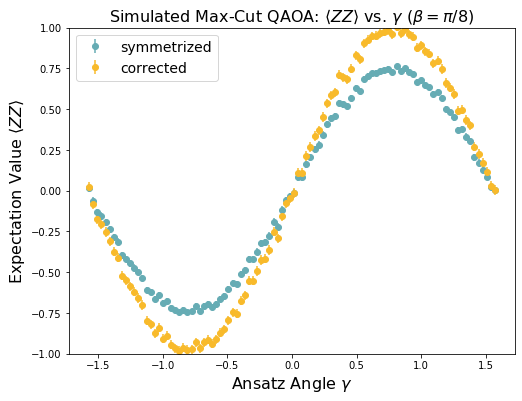

In [9]:
fig_qvm = plt.figure(figsize=(8, 6))
plt.errorbar(gammas, means, yerr=stderrs, color="#66acb4", fmt="o", label="symmetrized")
plt.errorbar(gammas, means_corrected, yerr=stderrs_corrected, color="#f8ba2b", fmt="o", label="corrected")
plt.title(rf"Simulated Max-Cut QAOA: $\langle ZZ \rangle$ vs. $\gamma$ ($\beta = \pi/8$)", fontsize=16)
plt.xlabel(r"Ansatz Angle $\gamma$", fontsize=16)
plt.ylabel(r"Expectation Value $\langle ZZ \rangle$", fontsize=16)
plt.legend(fontsize=14)
plt.ylim(-1, 1);